<a href="https://colab.research.google.com/github/yvrjsharma/HugginFace_Gradio/blob/main/Using_HFHub_for_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune any state-of-the-art Vision model like ConvNext for Image Classification

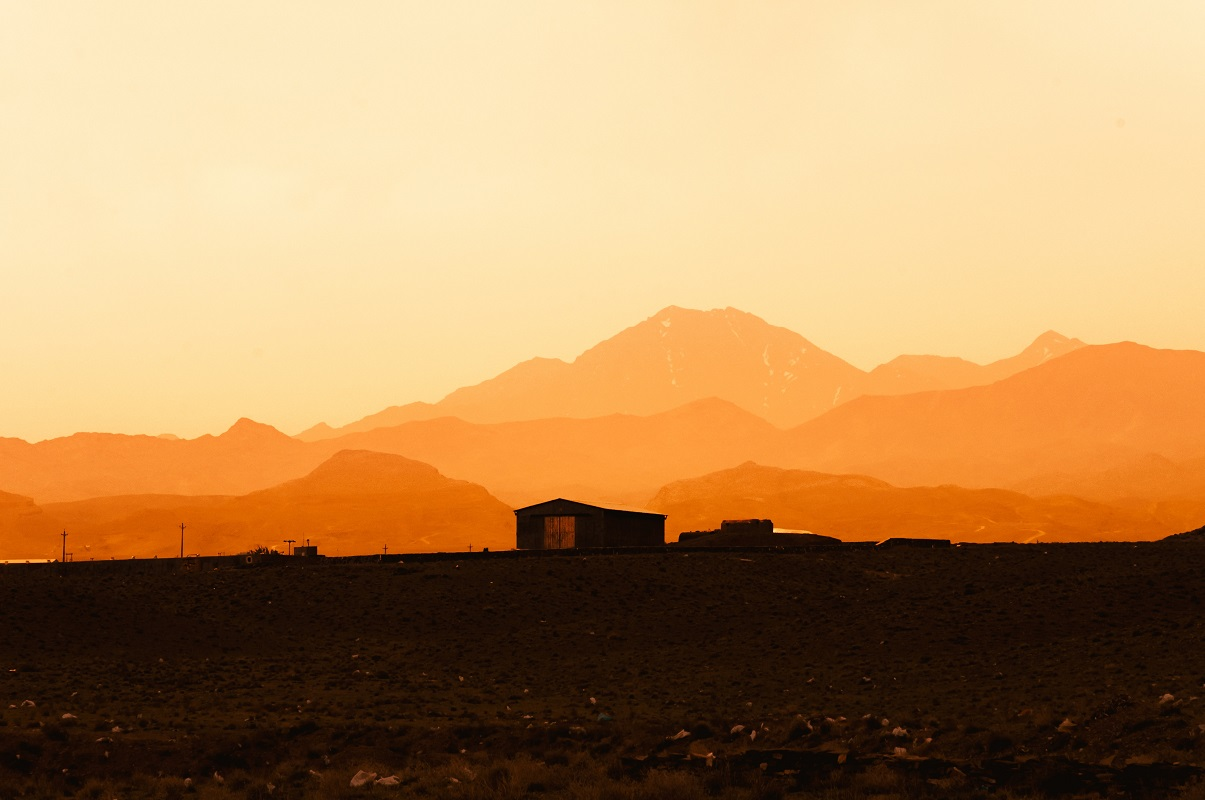
Credit: Photo by <a href="https://unsplash.com/@nimamot?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Nima Mot</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  


- Using Hugging Face Transformers Library + Pytorch 
- ConvNext is a new framework from Facebook which claims to outperform ViT, Swin Transformer etc. on Imagenet classifctaion task.
- We will be using [ImageFolder](https://huggingface.co/docs/datasets/image_process#imagefolder) method from Hub and show how it is useful in handling image data.
- You can load any custom image folder havng images from your machine, or any url for a zipped folder can also be used. This creates a huggingface dataset object.
- Once you have your image data as a HF dataset object you can do lots of fast operations like Map, Data Augmentation etc.

### Set-up environment

In [22]:
!pip install -q transformers datasets

### Loading Dataset
- Let's load [Eurosat dataset](https://github.com/phelber/EuroSAT) which is a collection of 27000 images taken from satellites (Sentinels) and is diviided into 10 classes based on land use like forest, river, highwasys, temperate forest, industrial land etc. So thi is a multi-class classification problem.
- Lets load the dataset as HF dataset first and then puch to HF.

In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

Using custom data configuration default-0537267e6f812d56


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-0537267e6f812d56/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

- Inspecting dataset

In [4]:
dataset #prints a datset dictionary

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [5]:
dataset["train"]  #gives you actual HF dataset object with two columns

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})

- Here we have two columns in our dataset - Image and label
- Image column is of type Image, which is nothing but a feature in HF dataset library
- Label column is of type ClassLabel

In [6]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

- Lets get the name of classes from Label column

In [7]:
labels = dataset["train"].features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


- Lets get the idea of type of images present inside the dataset. We will use cool feature of HF dataset which allows us to display images right here in the notebook -

In [8]:
example = dataset["train"][0] #getting first element from the dataset  
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FA2DB26F610>,
 'label': 0}

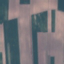

In [9]:
example["image"]  #how cool is that!!

In [10]:
example["label"] #gives you id

0

- Lets create a mapping of these label ids to label names 

In [13]:
id2label = {k:v for k,v in enumerate(labels)}
print(id2label)
print(id2label[0])  #gives you the correct class for id 0

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
AnnualCrop


- Lets create a reverse mapping of class label names to ids too

In [14]:
label2id = {v:k for k,v in enumerate(labels)}
label2id

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

- **Pushing the Dataset to hub**

In [16]:
from huggingface_hub import notebook_login

notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [17]:
dataset.push_to_hub("ysharma/eurosat-demo")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

- Uploading our dataset to Hub helps in reloading the dataset easily and wherever we want like shown in below example -
```
from datasets import load_dataset
reloaded_dataset = load_dataset("ysharma/eurosat-demo")
```
- This is a cool feature which can allow us to share our dataset with anyone we want to.

### ConvNext model
- Can be accessed from Hub [here](https://huggingface.co/docs/transformers/main/en/model_doc/convnext#convnext) 
- convnext is a image classification model and is inspired by resnet and swin transformer
- Every vision model on hub has feature called FeatureExtractor. Its function is to prepare images for the model for inference. Its vital for using a vision model to knoww how you can prepare images for it.
- convnext feature extractor would help with resizing the imege, normalizing pixel values and so on.
- Next, we have to decide on the checkpoint of the model that we would want to use for our task. Lets look on the Hub again for this. For the purpose of this notebook we are going ahead with convnext tiny model - [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224), checkpoint from the hub.
- We will start by loading the corresponding feature extractor

In [19]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224") #this loads the corresponding preprocessor config from - https://huggingface.co/facebook/convnext-tiny-224/blob/main/preprocessor_config.json

- Lets look at the config just loaded and observe details like
  - image size expected is 224 (cross 224)
  - mean and std dev for the images that will be used for the images passed onto model

In [20]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



**Data Processing**
- Performing data augmentation using [torchvision](https://pytorch.org/vision/stable/transforms.html) package from pytorch. You may want to use Albumentations or imgaug too if you want 
- Resizing, flipping of images comes under augmentation. This is done primarily to make our vision model more robust in its predictions



In [28]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor
)

#normalizing the image pixel values using preprocessor config from above
#so we will be using imagenet means and std dev that is coming up with the mode
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

#Definning all transformation here as a list 
transform = Compose(
    [
     RandomResizedCrop(feature_extractor.size), 
     RandomHorizontalFlip(),
     ToTensor(), #as images are coming in as Pillow object
     normalize
    ]
)

- Defining a custom function that we can apply to entire HF dataset

In [26]:
#input is dictionary of examples from HF dataset
def train_transforms(examples):
  #adding new column to dataset
  examples["pixel_values"] = [transform(image.convert('RGB')) for image in examples["image"]]

  #returning examples dictionary 
  return examples

- Applying these transformations on entire dataset in example batches of 1000

In [33]:
transformed_dataset = dataset.map(train_transforms, batched=True)

  0%|          | 0/27 [00:00<?, ?ba/s]

- We can either apply on entire dataset like above or apply our transformations on the fly. On the fly would mean applying transformations only while passing the images to model. This can be done using ``` with_transform ``` functionality of HF dataset.

In [30]:
processed_dataset = dataset.with_transform(train_transforms)

processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [31]:
processed_dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})

- Performing image transformations defined above, on the fly or whenever you need them. Notice the new column pixel_values added to the processed dataset example

In [32]:
processed_dataset["train"][0]  

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FA2C03EDB10>,
 'label': 0,
 'pixel_values': tensor([[[ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          [ 0.1768,  0.1768,  0.1768,  ..., -1.2788, -1.2788, -1.2788],
          ...,
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624],
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624],
          [-1.1418, -1.1418, -1.1418,  ...,  0.2624,  0.2624,  0.2624]],
 
         [[ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.6702, -0.6702, -0.6702],
          ...,
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0.1352,  0.1352],
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0.1352,  0.1352],
          [-0.5651, -0.5651, -0.5651,  ...,  0.1352,  0

In [36]:
processed_dataset["train"][0]["pixel_values"].shape  #which will be passed on to the model

torch.Size([3, 224, 224])

### Defining the model
- Getting the model for fine-tuning using [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto) of Huggingface transformers library
- Auto Classes API helps in making sure that based on your Hub model checkpoint provided you instantiate the correct classes
- For example here behind the scenes Auto Class will automatically instantiate the [ConvNextForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/convnext#transformers.ConvNextForImageClassification) class for us.
- Since we are putting a custom classification head of 10 Eurosat classes, we have to set number of labels explicitly as 10
- Providing label <-> id mapping for inference  

In [39]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model

- Next we would want to train (fine-tune) our model on our new dataset. We can do this in either of these ways-
  - Simple native pytorch training 
  - Huggingface [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer)
  - Hugginngface [Accelerate library](https://github.com/huggingface/accelerate)
  - Pytorch lightnening, etc

  First, moving the model to GPU

In [ ]:
import torch

#Putting model on the device - GPU
device = 'cuda' if torch.cuda.is_available else 'cpu'
model.to(device) 

- Using data loader - to iterate over the dataset batches and provide it to the model
  - We only need the pixel_values and labels from our processed dataset
  - Looking at the ConvNextForImageClassification documentation on Hub:
  

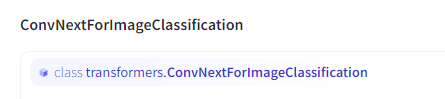

  - pixel_values need to be a tensor of shape (batch_size, num_channels, height, width), while labels need to be a tensor of shape (batch_size,) 

  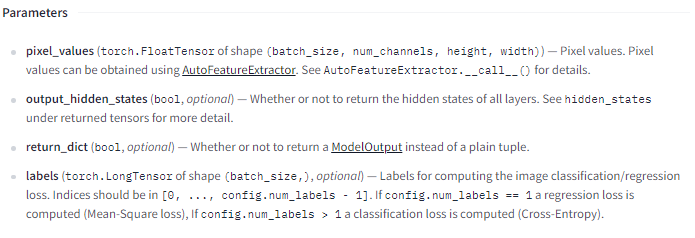 

- Lets define a custom collate function to get pixel_values and labels from your dataset together in form of required tensors in batches

In [44]:
processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

In [47]:
from torch.utils.data import DataLoader

#Custom collate function to tell how batch are formed 
def collate_fn(examples):
  #stacking examples
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  #returning a dictionary
  return {"pixel_values":pixel_values, "labels":labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle= True)

- Lets verify by looking at the first batch of dataloader

In [57]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


- Model optimizer
- Forward pass
- Look at the model card on Hub : Model returns loss (Float tensor shape (1,) and logits (Float tensor of shape(batch_size, number of labels)
- Basic Training loop
  - Take batch (pixel_values and labels) from your dataloader
  - move the batches to device (GPU) as model is already on device (GPU)
  - Pytorch accumulates gradients by default so we need to zero grad them
  - Perform a forward pass, obtain loss and logits
  - Call backward or do back propagation 
  - Perform optimization step
  - mention the metrics that we want to track
  - Train for 10 epochs



In [59]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#putting model in training mode
model.train()
for epoch in range(10):
  print("Epoch: ", epoch)

  #for monitoring accuracy
  correct = 0
  total = 0

  #go through your dataloader batches
  for idx, batch in enumerate(tqdm(dataloader)):
    #make sure whole batch is on device
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    #forward pass
    outputs = model(pixel_values = batch["pixel_values"],
                    labels = batch["labels"])
    
    loss, logits  = outputs.loss, outputs.logits

    #calcuate gradiengts
    loss.backward()

    #take a step using our optimizer
    optimizer.step()

    #metrics
    total += batch["labels"].shape[0]
    #taking argmax to get predictions from logits (on labels dimension)
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()
    accuracy = correct / total

    #printing the metrics every 100 btches
    if idx % 1000 == 0:
      print(f"Loss after {idx} steps : ", loss.item())
      print(f"Accuracy after {idx} steps :", accuracy )


Epoch:  0


  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.3841509222984314
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.20216678082942963
Accuracy after 100 steps : 0.8267326732673267
Loss after 200 steps :  0.24633440375328064
Accuracy after 200 steps : 0.8519900497512438
Loss after 300 steps :  0.037074871361255646
Accuracy after 300 steps : 0.8621262458471761
Loss after 400 steps :  0.49395087361335754
Accuracy after 400 steps : 0.8728179551122195
Loss after 500 steps :  0.7312549948692322
Accuracy after 500 steps : 0.8737524950099801
Loss after 600 steps :  0.052137743681669235
Accuracy after 600 steps : 0.8768718801996672
Loss after 700 steps :  0.0753604918718338
Accuracy after 700 steps : 0.8808844507845934
Loss after 800 steps :  0.6387141942977905
Accuracy after 800 steps : 0.8873283395755306
Loss after 900 steps :  0.7682334780693054
Accuracy after 900 steps : 0.8898446170921198
Loss after 1000 steps :  1.8503365516662598
Accuracy after 1000 steps : 0.8916083916083916
Loss after 1100 steps :  0.0805

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.7772656083106995
Accuracy after 0 steps : 0.5
Loss after 100 steps :  0.3714601397514343
Accuracy after 100 steps : 0.9529702970297029
Loss after 200 steps :  0.043147455900907516
Accuracy after 200 steps : 0.9465174129353234
Loss after 300 steps :  0.02446054480969906
Accuracy after 300 steps : 0.9476744186046512
Loss after 400 steps :  0.006037380080670118
Accuracy after 400 steps : 0.9457605985037406
Loss after 500 steps :  0.8779153823852539
Accuracy after 500 steps : 0.9436127744510978
Loss after 600 steps :  0.006053438410162926
Accuracy after 600 steps : 0.9434276206322796
Loss after 700 steps :  0.016492800787091255
Accuracy after 700 steps : 0.9447218259629101
Loss after 800 steps :  0.0032823695801198483
Accuracy after 800 steps : 0.9456928838951311
Loss after 900 steps :  0.016086583957076073
Accuracy after 900 steps : 0.9470033296337403
Loss after 1000 steps :  0.15000607073307037
Accuracy after 1000 steps : 0.948051948051948
Loss after 1100 steps : 

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.3795424997806549
Accuracy after 0 steps : 0.75
Loss after 100 steps :  0.005399259738624096
Accuracy after 100 steps : 0.9579207920792079
Loss after 200 steps :  0.0060329921543598175
Accuracy after 200 steps : 0.9626865671641791
Loss after 300 steps :  0.8027361035346985
Accuracy after 300 steps : 0.9568106312292359
Loss after 400 steps :  0.04999873787164688
Accuracy after 400 steps : 0.9569825436408977
Loss after 500 steps :  0.005180610343813896
Accuracy after 500 steps : 0.9565868263473054
Loss after 600 steps :  0.042528897523880005
Accuracy after 600 steps : 0.9559068219633944
Loss after 700 steps :  0.26669806241989136
Accuracy after 700 steps : 0.9572039942938659
Loss after 800 steps :  0.8533197641372681
Accuracy after 800 steps : 0.9553682896379525
Loss after 900 steps :  0.0594429112970829
Accuracy after 900 steps : 0.9572697003329633
Loss after 1000 steps :  0.015343058854341507
Accuracy after 1000 steps : 0.9575424575424576
Loss after 1100 steps : 

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.016938213258981705
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.06530999392271042
Accuracy after 100 steps : 0.9702970297029703
Loss after 200 steps :  0.048621371388435364
Accuracy after 200 steps : 0.9626865671641791
Loss after 300 steps :  0.6308083534240723
Accuracy after 300 steps : 0.9601328903654485
Loss after 400 steps :  0.020626310259103775
Accuracy after 400 steps : 0.9619700748129676
Loss after 500 steps :  0.08641628175973892
Accuracy after 500 steps : 0.9605788423153693
Loss after 600 steps :  0.6214191913604736
Accuracy after 600 steps : 0.9596505823627288
Loss after 700 steps :  0.29807671904563904
Accuracy after 700 steps : 0.9611269614835949
Loss after 800 steps :  0.01414621714502573
Accuracy after 800 steps : 0.9619225967540574
Loss after 900 steps :  0.0025320532731711864
Accuracy after 900 steps : 0.9617092119866815
Loss after 1000 steps :  0.011860985308885574
Accuracy after 1000 steps : 0.9617882117882118
Loss after 1100 steps :

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.017257412895560265
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.008013337850570679
Accuracy after 100 steps : 0.9653465346534653
Loss after 200 steps :  0.0017141917487606406
Accuracy after 200 steps : 0.9564676616915423
Loss after 300 steps :  0.10545565187931061
Accuracy after 300 steps : 0.9509966777408638
Loss after 400 steps :  0.12875591218471527
Accuracy after 400 steps : 0.9488778054862843
Loss after 500 steps :  0.0015828425530344248
Accuracy after 500 steps : 0.9515968063872255
Loss after 600 steps :  0.11494427174329758
Accuracy after 600 steps : 0.9525790349417638
Loss after 700 steps :  0.07575441151857376
Accuracy after 700 steps : 0.9547075606276747
Loss after 800 steps :  0.6019578576087952
Accuracy after 800 steps : 0.9566167290886392
Loss after 900 steps :  0.4556701183319092
Accuracy after 900 steps : 0.9578246392896781
Loss after 1000 steps :  0.045646801590919495
Accuracy after 1000 steps : 0.9595404595404595
Loss after 1100 steps 

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.010411703959107399
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.001636011991649866
Accuracy after 100 steps : 0.9678217821782178
Loss after 200 steps :  0.20811279118061066
Accuracy after 200 steps : 0.9701492537313433
Loss after 300 steps :  0.06357115507125854
Accuracy after 300 steps : 0.9725913621262459
Loss after 400 steps :  0.0013106282567605376
Accuracy after 400 steps : 0.9706982543640897
Loss after 500 steps :  0.0019106467952951789
Accuracy after 500 steps : 0.9720558882235529
Loss after 600 steps :  0.041567251086235046
Accuracy after 600 steps : 0.9737936772046589
Loss after 700 steps :  0.04976972937583923
Accuracy after 700 steps : 0.9718259629101283
Loss after 800 steps :  0.002367778681218624
Accuracy after 800 steps : 0.9715980024968789
Loss after 900 steps :  0.03800974413752556
Accuracy after 900 steps : 0.9705882352941176
Loss after 1000 steps :  0.14037185907363892
Accuracy after 1000 steps : 0.9687812187812188
Loss after 1100 ste

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.0009744620183482766
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.1963939070701599
Accuracy after 100 steps : 0.9653465346534653
Loss after 200 steps :  0.16182947158813477
Accuracy after 200 steps : 0.9626865671641791
Loss after 300 steps :  0.35483449697494507
Accuracy after 300 steps : 0.9626245847176079
Loss after 400 steps :  0.02363472431898117
Accuracy after 400 steps : 0.9644638403990025
Loss after 500 steps :  0.009428967721760273
Accuracy after 500 steps : 0.966566866267465
Loss after 600 steps :  0.0023311700206249952
Accuracy after 600 steps : 0.9650582362728786
Loss after 700 steps :  0.01922457106411457
Accuracy after 700 steps : 0.9668330955777461
Loss after 800 steps :  0.007840782403945923
Accuracy after 800 steps : 0.9666042446941323
Loss after 900 steps :  0.14632005989551544
Accuracy after 900 steps : 0.9661487236403996
Loss after 1000 steps :  0.017332302406430244
Accuracy after 1000 steps : 0.967032967032967
Loss after 1100 steps :

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.0028003589250147343
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.023849867284297943
Accuracy after 100 steps : 0.9826732673267327
Loss after 200 steps :  0.0009261969244107604
Accuracy after 200 steps : 0.9763681592039801
Loss after 300 steps :  0.0017538254614919424
Accuracy after 300 steps : 0.9750830564784053
Loss after 400 steps :  0.0027249350678175688
Accuracy after 400 steps : 0.9738154613466334
Loss after 500 steps :  0.8258204460144043
Accuracy after 500 steps : 0.9735528942115769
Loss after 600 steps :  0.013759221881628036
Accuracy after 600 steps : 0.9725457570715474
Loss after 700 steps :  1.061490535736084
Accuracy after 700 steps : 0.9700427960057061
Loss after 800 steps :  0.005340145900845528
Accuracy after 800 steps : 0.9694132334581773
Loss after 900 steps :  0.01042698323726654
Accuracy after 900 steps : 0.9680910099889012
Loss after 1000 steps :  0.0032751010730862617
Accuracy after 1000 steps : 0.9675324675324676
Loss after 1100 s

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.0032329161185771227
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.07879064232110977
Accuracy after 100 steps : 0.9752475247524752
Loss after 200 steps :  0.6558108329772949
Accuracy after 200 steps : 0.9751243781094527
Loss after 300 steps :  0.00073870865162462
Accuracy after 300 steps : 0.9742524916943521
Loss after 400 steps :  0.004474358633160591
Accuracy after 400 steps : 0.9731920199501247
Loss after 500 steps :  0.0008553337538614869
Accuracy after 500 steps : 0.9745508982035929
Loss after 600 steps :  0.06207510828971863
Accuracy after 600 steps : 0.9729617304492513
Loss after 700 steps :  0.01802714541554451
Accuracy after 700 steps : 0.9728958630527818
Loss after 800 steps :  0.03910335525870323
Accuracy after 800 steps : 0.9731585518102372
Loss after 900 steps :  0.007104113698005676
Accuracy after 900 steps : 0.9714206437291898
Loss after 1000 steps :  0.017415136098861694
Accuracy after 1000 steps : 0.9712787212787213
Loss after 1100 steps

  0%|          | 0/6750 [00:00<?, ?it/s]

Loss after 0 steps :  0.053572237491607666
Accuracy after 0 steps : 1.0
Loss after 100 steps :  0.11759915202856064
Accuracy after 100 steps : 0.9603960396039604
Loss after 200 steps :  0.10609986633062363
Accuracy after 200 steps : 0.9664179104477612
Loss after 300 steps :  0.057855114340782166
Accuracy after 300 steps : 0.9659468438538206
Loss after 400 steps :  0.014102202840149403
Accuracy after 400 steps : 0.963216957605985
Loss after 500 steps :  0.0016147202113643289
Accuracy after 500 steps : 0.966566866267465
Loss after 600 steps :  0.0007619940442964435
Accuracy after 600 steps : 0.9667221297836939
Loss after 700 steps :  0.15303274989128113
Accuracy after 700 steps : 0.9682596291012838
Loss after 800 steps :  0.008675750344991684
Accuracy after 800 steps : 0.9675405742821473
Loss after 900 steps :  0.008207889273762703
Accuracy after 900 steps : 0.9669811320754716
Loss after 1000 steps :  0.002565769711509347
Accuracy after 1000 steps : 0.9677822177822177
Loss after 1100 ste

## Pushing Model and Feature Extractor to Hub
Feature extractor will help us in preparing images at the time of model inference. Hosting model on Hub can have multiple benefts - 
- To share it with wider community or team
- To use it in future

Lets tore it in my repository as -
``` ysharma/convnext-tiny-eurosat2700-finetuned  ``` 

The following code will  create a new repo on Hub, and starts uploading model.bin file or the model weights and the configuration json files using git-lfs to this repo.

In [60]:
repo_name = 'ysharma/convnext-tiny-eurosat2700-finetuned'

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='convnext-tiny-eurosat2700-finetuned' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/ysharma/convnext-tiny-eurosat2700-finetuned into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/106M [00:00<?, ?B/s]

To https://huggingface.co/ysharma/convnext-tiny-eurosat2700-finetuned
   dfc9909..72cc718  main -> main

To https://huggingface.co/ysharma/convnext-tiny-eurosat2700-finetuned
   72cc718..22ad9be  main -> main



'https://huggingface.co/ysharma/convnext-tiny-eurosat2700-finetuned/commit/22ad9befc9bb7daf1c21058f49c20afccc634d42'

## Model Inference

- You can load again the model that you have loaded once to Hub as follows
- The Auto Class API helps to this regard : AutoFeatureExtractor and AutoModelForImageClassification

In [62]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("ysharma/convnext-tiny-eurosat2700-finetuned")
model = AutoModelForImageClassification.from_pretrained("ysharma/convnext-tiny-eurosat2700-finetuned")

- Get a URL of any satellite image from internet to see how well your model is performing 

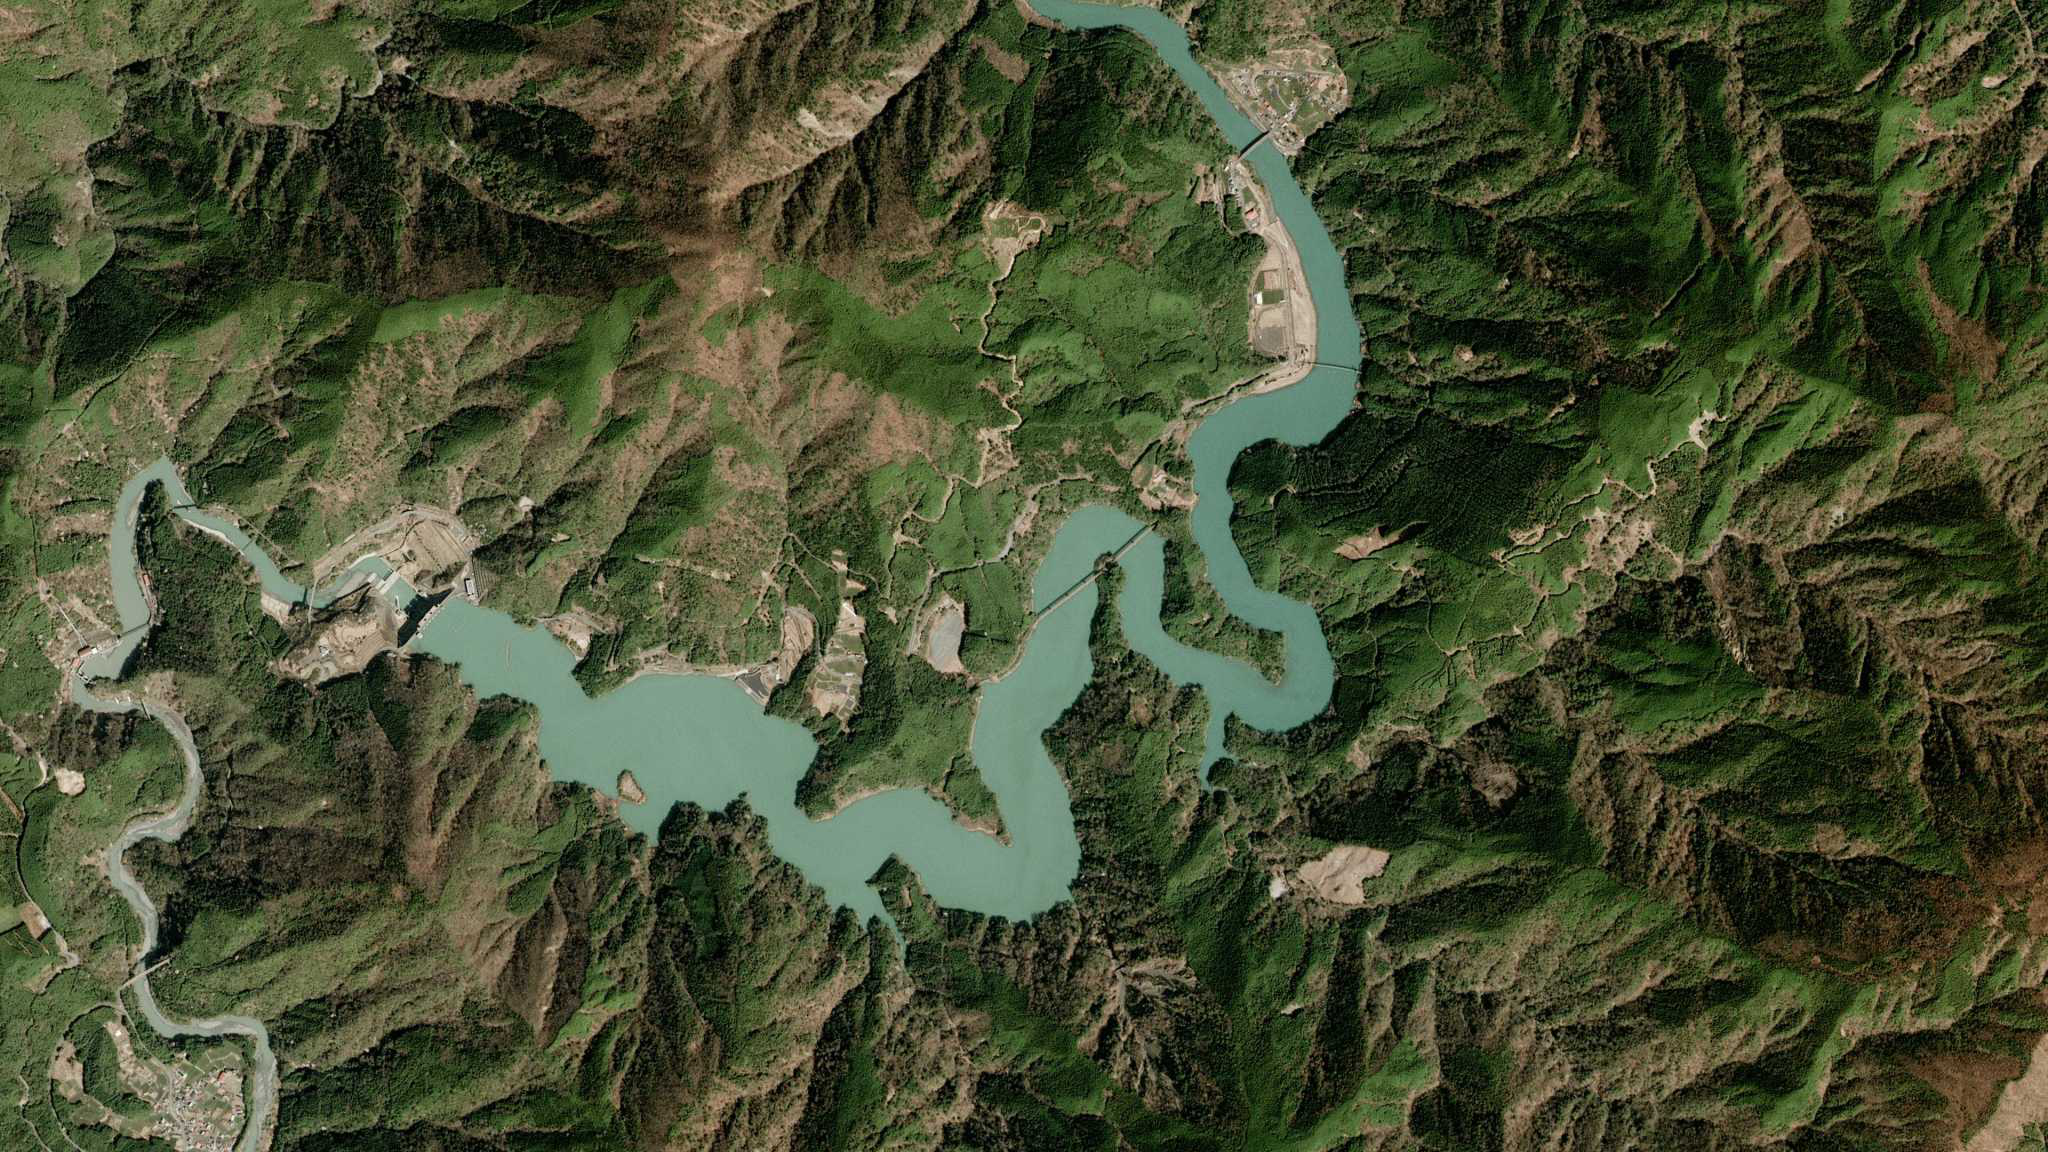

In [63]:
from PIL import Image
import requests

url = "https://images.ctfassets.net/nzn0tepgtyr1/2pmLvSHSdztXnaPaui6Gme/510c328dd318041752bc4f534f6c073f/satellite-river-forest.jpg?w=2048&q=50"
image = Image.open(requests.get(url,stream=True).raw)

#displaying image once
image

- Lets prepare image for the model or turn the image into pixel_values using our feature extractor

In [64]:
pixel_values = feature_extractor(image.convert('RGB'),return_tensors='pt').pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


- Perform a forward pass, and since we are using pytorch, making sure no gradients are computed while doing an ineference

In [65]:
import torch 

#using context manager
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

#shape of logits - (Batch size, num. of labels)
print(logits.shape)

torch.Size([1, 10])


In [66]:
#Get the labels by getting the highest normalised score label
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

HerbaceousVegetation


- So inference can be explained in following steps -
  - First read in an image
  - Prepare the image for the model using feature extractor
  - Perform Forward pass
  - Get prediction rsult as class name or top 5 predictions for an image

